In [1]:
import torch as T
import shap
import matplotlib.pyplot as plt
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing
from src.regressors.transformer_regressor import ConsumptionTransformerRegressor, ConsumptionTSTRegressor
from src.dataset import PecanDataset, PecanDataModule
from torch.utils.data import DataLoader
%matplotlib inline
shap.initjs()

In [2]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_all', 'data/participants_data/1min/', 60, task='test')
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

[!] - Trainable dataframe shape - (129086, 28)
[*] Train dataframe shape: (90360, 28)
[*] Validation dataframe shape: (25817, 28)
[*] Test dataframe shape: (12909, 28)


100%|█████████████████████████████████████████████████████████████████████████| 12849/12849 [00:01<00:00, 12708.26it/s]

[!] Val sequence shape: (60, 28)
[!] Test sequence shape: (60, 28)


In [3]:
ckpt = 'etc/ckpts/participants/661_test_30_all/sigmoid/GRU/best/best-GRU-chpkt-pecanstreet-participant-id-661_test_30_all_epoch=080-val_loss=0.00000.ckpt'
scaler = pecan_dataset.scaler

In [4]:
shap_train_sequence = PecanDataset(pecan_dataset.val_sequences, device)
shap_test_sequence = PecanDataset(pecan_dataset.test_sequences, device)

In [5]:
shap_train_loader = DataLoader(
            shap_train_sequence,
            batch_size=32,
            shuffle = False,
            num_workers=0,
            pin_memory=True)

shap_test_loader = DataLoader(
            shap_test_sequence,
            batch_size=10000,
            shuffle = False,
            num_workers=0,
            pin_memory=True)

In [6]:
shap_train_batch = next(iter(shap_train_loader))
shap_test_batch = next(iter(shap_test_loader))

In [7]:
sequences = shap_train_batch["sequence"]
labels = shap_train_batch["label"]
background = sequences.to(device)
background.shape

torch.Size([32, 60, 28])

In [8]:
model = ConsumptionTSTRegressor.load_from_checkpoint(checkpoint_path=ckpt, scaler=scaler,
                                                                 strict=False,
                                                                 device=device,
                                                                 n_features=pecan_dataset.get_n_features(),
                                                                 seq_len=60,
                                                                 max_seq_len=120, d_model=128,
                                                                 n_head=16,
                                                                 d_k=32, d_v=32, d_ffn=256,
                                                                 res_dropout=0.1,
                                                                 n_layers=3, lr=1e-5,
                                                                 activation_function='gelu',
                                                                 fc_dropout=0.1)


Found keys that are in the model state dict but not in the checkpoint: ['model.W_pos', 'model.W_P.weight', 'model.W_P.bias', 'model.encoder.layers.0.self_attn.W_Q.weight', 'model.encoder.layers.0.self_attn.W_K.weight', 'model.encoder.layers.0.self_attn.W_V.weight', 'model.encoder.layers.0.self_attn.W_O.weight', 'model.encoder.layers.0.batchnorm_attn.weight', 'model.encoder.layers.0.batchnorm_attn.bias', 'model.encoder.layers.0.batchnorm_attn.running_mean', 'model.encoder.layers.0.batchnorm_attn.running_var', 'model.encoder.layers.0.ff.0.weight', 'model.encoder.layers.0.ff.0.bias', 'model.encoder.layers.0.ff.2.weight', 'model.encoder.layers.0.ff.2.bias', 'model.encoder.layers.0.batchnorm_ffn.weight', 'model.encoder.layers.0.batchnorm_ffn.bias', 'model.encoder.layers.0.batchnorm_ffn.running_mean', 'model.encoder.layers.0.batchnorm_ffn.running_var', 'model.encoder.layers.1.self_attn.W_Q.weight', 'model.encoder.layers.1.self_attn.W_K.weight', 'model.encoder.layers.1.self_attn.W_V.weight', 

In [9]:
gru_model = model.model

In [10]:
explainer = shap.DeepExplainer(gru_model, background)

In [11]:
test_sequences = shap_test_batch["sequence"]
test_labels = shap_test_batch["label"]
shap_test = test_sequences.to(device)


In [12]:
T.backends.cudnn.enabled = False
shap_values = explainer.shap_values(shap_test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


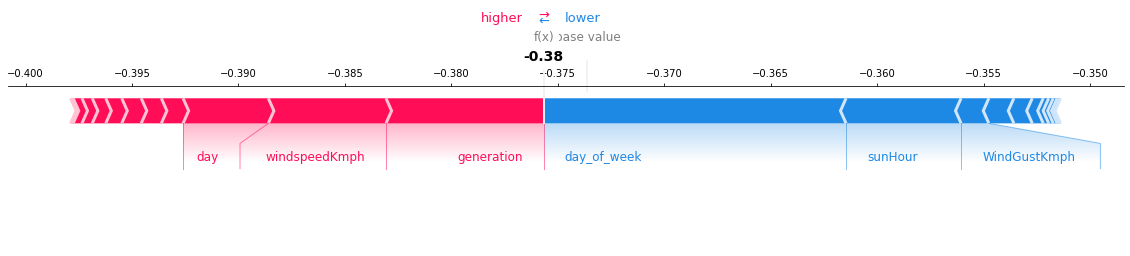

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], pecan_dataset.get_features_names(), show=False, matplotlib=True)
plt.style.use('fast')

plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/force_plots/TST/feature_impact.svg', dpi=600, bbox_inches='tight')
plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/force_plots/TST/feature_impact.eps', dpi=600, bbox_inches='tight')
plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/force_plots/TST/feature_impact.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
shap_values.shape

(10000, 60, 28)

In [15]:
shap_values[-1, :, :].shape

(60, 28)

In [16]:
import pandas as pd
import numpy as np
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values[-1, :, :]), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values[-1, :, :]), axis=0), 
    "name": pecan_dataset.get_features_names()
})
df.sort_values("mean_abs_shap", ascending=False)[:10]

,mean_abs_shap,stdev_abs_shap,name
5,0.010868,0.007972,day
12,0.007823,0.005328,sunHour
0,0.007305,0.004949,generation
4,0.006214,0.004021,day_of_week
20,0.005446,0.003435,cloudcover
21,0.005023,0.003904,humidity
26,0.004707,0.003353,winddirDegree
6,0.004527,0.002956,week_of_year
2,0.003926,0.003282,time_minute
19,0.003360,0.002684,WindGustKmph


In [17]:
shap_values[0,:, :]

array([[ 7.40527362e-03,  6.33792370e-04,  4.13253583e-04, ...,
         4.84266959e-04, -1.37455718e-04,  5.52686676e-03],
       [ 1.22501026e-03,  6.40246901e-04, -9.16603967e-05, ...,
        -8.72278004e-04, -9.76549927e-05, -2.57398991e-04],
       [ 1.71304075e-03, -5.32937411e-04, -3.67500528e-04, ...,
        -2.03809864e-03,  1.35581809e-04, -4.03467240e-03],
       ...,
       [-1.85665544e-04,  1.39924651e-03,  5.38359513e-04, ...,
         8.79944128e-04,  2.05517601e-04,  1.15388329e-03],
       [-2.68540443e-05,  6.91498688e-04, -5.08023368e-04, ...,
        -2.14682333e-03,  2.36960346e-04,  1.57363864e-03],
       [ 3.88987735e-03,  4.04337392e-04, -1.48641935e-04, ...,
        -8.42494657e-04, -4.04714403e-04,  9.78771248e-04]])

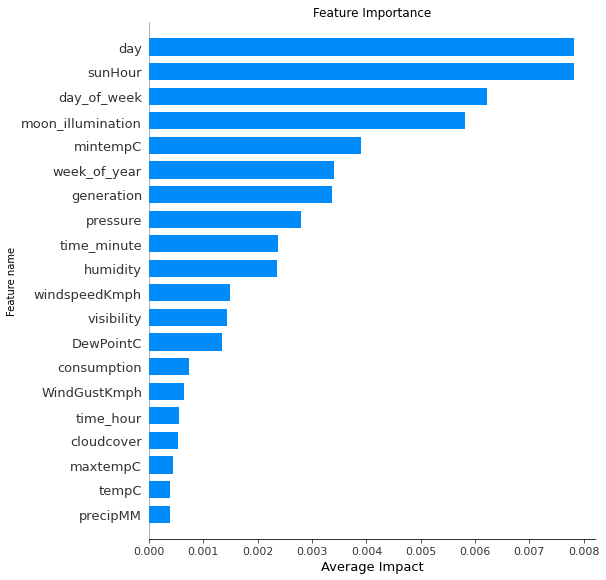

In [18]:
shap.summary_plot(shap_values[0, :, :], features=test_sequences[0, :,:], 
                  feature_names=pecan_dataset.get_features_names(), 
                  plot_type='bar', show=False)
plt.ylabel("Feature name")
plt.xlabel("Average Impact")
plt.title("Feature Importance")
plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/summary_plots/TST/feature_importance.svg', dpi=600, bbox_inches='tight')
plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/summary_plots/TST/feature_importance.eps', dpi=600, bbox_inches='tight')
plt.savefig(f'etc/imgs/features/661_test_30_all/shap_values/summary_plots/TST/feature_importance.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([pecan_dataset.get_features_names(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
53,None,"[0.0037654892836398177, 0.0060475928253436, 0.0009909834390706238, 0.0, 0.0127021579220891, 0.012186253028921783, 0.0035448968852870165, 8.250789880653429e-05, 0.0008408469531605988, 0.0011260768664069474, 0.001940820903517306, 0.0, 0.005284308160655201, 0.0019129989445209503, 0.007985481678624638, 0.0002907117219292559, 0.004579163694288581, 0.0030116570832033175, 0.0009473457093408797, 0.0024409099289914595, 0.012667317531304434, 0.001149738193358644, 0.001686733308393741, 4.136343464597303e-05, 0.0007399033461115323, 0.0034527738571632654, 0.0020729995055298787, 0.003179817358031869]"
46,None,"[0.0033805231865262613, 0.0001875710124856596, 0.004781387948439806, 0.0, 0.0017634519785642625, 0.022109198162704707, 0.004994247096218169, 0.0002610214374792974, 3.1300830475571926e-05, 0.0005699231621663785, 0.0011571992755867542, 0.0, 0.0036379006505012513, 0.0017193468734622002, 8.188333273328681e-05, 0.0005647837212425657, 0.0009246282137886738, 7.99062491125369e-05, 0.0005414819869183703, 0.004211872666858835, 0.002914452310978959, 0.001328837999926327, 0.001768827599589713, 0.0007519491374609061, 0.0003857703841829789, 0.00022521016957762185, 0.000922574262242415, 0.003277571397306..."
36,None,"[0.0033207095003127507, 0.004372197499335743, 0.003739179417002015, 0.0, 0.004823340434581041, 0.008154314648546278, 0.002293893215688877, 3.125900596265687e-05, 0.00033429966101770106, 0.0001221985557334847, 0.00034985704406281, 0.0, 0.00027903760969638826, 0.003181665301322937, 0.0019564871600392508, 0.0002742631668166723, 0.002177471606672043, 0.0030974726918531815, 0.0023375857169972733, 1.1053152493605013e-05, 0.006257660433178535, 0.004746647051878972, 0.0005610115894669434, 0.0005775378606864252, 0.0026968549621582496, 0.0024185500086750834, 0.0015204974242311437, 3.6634203517314745..."
11,totalSnow_cm,"[0.0031652063949488933, 0.002350132427900098, 0.0012649680233989785, 0.0, 0.008296452067792415, 0.011956962912529706, 0.0026972977075725795, 8.440276004932699e-05, 0.00015223247428428408, 0.002424720098823309, 0.0018905071817338468, 0.0, 0.0032932982491329314, 0.0006546213068068027, 0.0005528397527057678, 0.00021364757664268837, 0.0007587349160225131, 0.00042971141898306086, 0.0015394877737155185, 0.0006538292216602713, 0.007194815538462717, 0.0013998163616663077, 0.0012417585531948134, 0.00040247988662449644, 0.0011323012974695302, 0.0024244053207803516, 3.651182731227891e-05, 0.001839336..."
24,tempC,"[0.0031257957993874696, 0.00010997013689693631, 0.0019790940562801553, 0.0, 0.0006171448789536953, 0.008942874209256843, 0.00593918784596026, 0.00012228476509686318, 1.648158270597877e-05, 0.0004168114227271872, 0.002146524700243026, 0.0, 0.0005119635238079354, 0.0015113594681024551, 0.005389858805492986, 0.0006149234850658104, 0.0008688369748866535, 0.00020590085167495998, 0.002217284901655512, 0.0013571578425879125, 0.002630372332807747, 0.0010386348505155183, 0.0022270709656295367, 0.00032191697163798383, 0.001659238722146256, 0.0019604327301494776, 0.0010040984321538417, 0.002579211783..."
32,None,"[0.003102283878631806, 0.00823914333935245, 0.0007213872399290267, 0.0, 0.0005780306800734252, 0.014247173781879246, 0.006318703849986195, 8.63829380923466e-05, 0.00041142234184392236, 0.0007605902623065049, 0.002526953936647624, 0.0, 0.008198352979496122, 0.004109356641769409, 0.00039534487098535464, 0.0004706970949540846, 0.0008811293293139897, 0.0019507705446783802, 0.0003989811958068458, 0.004857368761627004, 0.007926480840769363, 0.00020279149967136618, 0.000532224855352979, 0.0006430498251225799, 0.0007500959173048614, 0.0021909656091593207, 0.0005042567641383357, 0.0021548670093237887]"
59,None,"[0.0028374764359708933, 0.0034936912438486615, 0.005211561231965606, 0.0, 0.004712864274159074, 0.01570326649621129, 0.003923879072628915, 0.00022449216910207497, 0.0001967190081524283, 0.0015957141264807432, 0.002715211632475257, 0.0, 0.0056942563029006125, 0.0025256159529089927, 0.001506707326415